# Single Data Optimization

## Initialization 

In [2]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Import Data

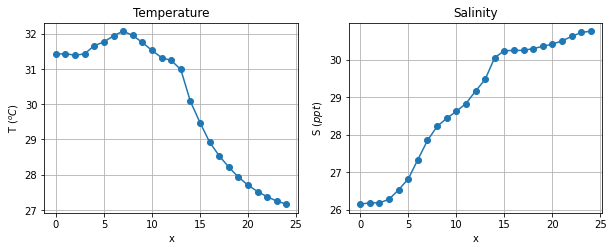

In [3]:
import pandas as pd
df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)

from utils.general import data_normalization
temperature = df[2].to_numpy()
salinity = df[3].to_numpy()

nx = len(temperature) - 1
x = np.linspace(0, nx, nx +1)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
ax[0]. plot(x,temperature,'o-')
ax[0].set_title('Temperature')
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'T ($^o C$)')
ax[0].grid('on')

ax[1].plot(x,salinity,'o-')
ax[1].set_title('Salinity')
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'S ($ppt$)')
ax[1].grid('on')

# temperature = data_normalization(temperature, 31.0, df[2].to_numpy().ptp())
# salinity = data_normalization(salinity, 33.5, df[3].to_numpy().ptp())


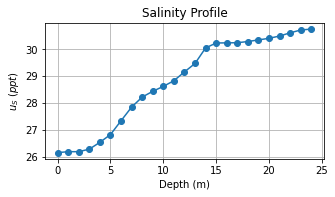

In [4]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 2.5))
# ax. plot(x,temperature,'o-')
# ax.set_title('Temperature Profile')
# ax.set_xlabel('Depth (m)')
# ax.set_ylabel(r'$u_T$ ($^o C$)')
# ax.grid('on')
# plt.savefig('./log/img/temperature_profile.eps', format='eps',dpi=250, bbox_inches='tight')

# ax.plot(x,salinity,'o-')
# ax.set_title('Salinity Profile')
# ax.set_xlabel('Depth (m)')
# ax.set_ylabel(r'$u_S$ ($ppt$)')
# ax.grid('on')
# plt.savefig('./log/img/salinity_profile.eps', format='eps',dpi=250, bbox_inches='tight')

## Initialization

In [131]:
nx = nx
a,b = 0,1
bc_type = 'NBC'
omega = 1.0
oce_val = 0.0 if bc_type == 'DBC' else -0.2
gamma =1.043e-4 if bc_type == 'DBC' else 1.6e-3
gamma = 1.0e-6
run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=0.0)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Distribution forcing

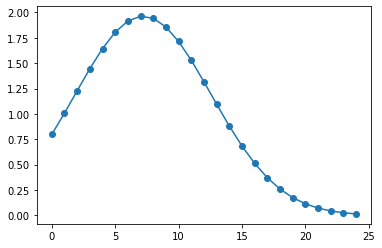

In [132]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boudnary Condition

In [133]:
uL = temperature[0] if bc_type == 'DBC' else 1.0
uR = temperature[-1] if bc_type == 'DBC' else 0.0
print(f'uL: {uL}, uR: {uR}')
run.BC_setup(uL, uR)

uL: 1.0, uR: 0.0


## Forcing $g$

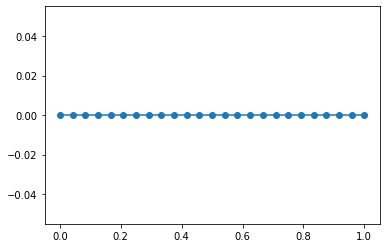

In [134]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.2 if bc_type == 'DBC' else 0.9
gauss_var = 1/10
g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g = normalize_function(g_str, run.Vm, ufl.dx)
g_array = g.compute_vertex_values()

coef = 0.25 if bc_type == 'DBC' else 0.0
g.vector().set_local(g_array[::-1]*coef)
run.extra_f_setup(g = g)
plt.plot(x, g.compute_vertex_values(), 'o-')

## Data Setup

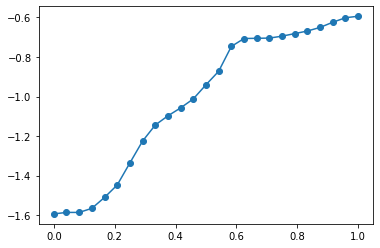

In [135]:
ud_array = temperature if bc_type == 'DBC' else salinity
run.data_setup(ud_array=ud_array, normalize=False)
plt.plot(x, run.ud.compute_vertex_values(), 'o-')

## Initial Guess Setup

sum wrong
1.0 0.0


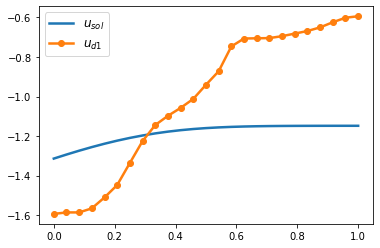

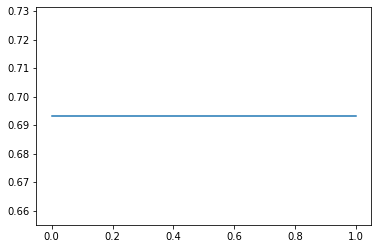

In [136]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    # print(y1[0], y1[-1])
elif bc_type == 'NBC':
    try:
        print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
        print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    except:
        print('sum wrong')
    print(uL, uR)

plt.plot(x,u.compute_vertex_values(), label=r'$u_{sol}$',linewidth=2.5)
plt.plot(x,run.ud.compute_vertex_values(),'o-', label=r'$u_{d1}$',linewidth=2.5)
plt.legend(prop={'size':12})
plt.show()

# plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

## Optimization Step

In [137]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     4.41947e-02   8.83893e-02   3.12098e-08   1.16220e-01   2.10469e-02   1.00e+00   5.000e-01
 2     1     2.38737e-02   4.77472e-02   1.01140e-07   1.37877e-01   3.69404e-02   1.00e+00   5.000e-01
 3     1     1.49617e-02   2.99233e-02   1.57733e-07   1.08646e-01   3.88493e-02   1.00e+00   5.000e-01
 4     1     1.39173e-02   2.78344e-02   1.68214e-07   4.28760e-02   2.79585e-02   1.00e+00   5.000e-01
 5     2     1.16680e-03   2.31619e-03   1.74082e-05   1.56262e-01   3.14786e-02   1.00e+00   5.000e-01
 6     1     1.13885e-03   2.26025e-03   1.74540e-05   7.32808e-03   5.53301e-03   1.00e+00   5.000e-01
 7     4     8.97393e-04   1.77230e-03   2.24869e-05   4.26611e-01   4.31081e-03   7.81e-03   4.526e-01
 8     1     5.58041e-04   1.09360e-03   2.24854e-05   2.47388e-02   8.54668e-03   1.00e+00   5.000e-01
 9     2     4.84919e-04   9.49434e-04   2.04039e-05   1.17010e-02   2.

## Plot Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


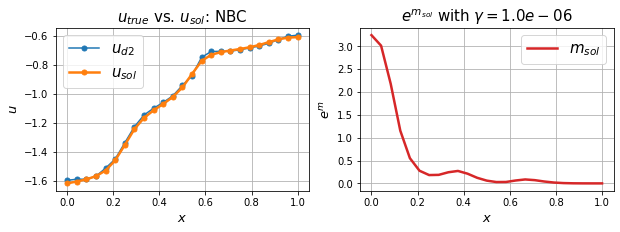

In [139]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

# ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
# ax[0].grid('on')
# ax[0].set_xlabel(r'$x$', fontsize=13)
# ax[0].set_ylabel(r'$f$', fontsize=13)
# ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# # ax[0].legend()
# ax[0].legend(prop={'size':12})

if bc_type == 'DBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=5)
elif bc_type == 'NBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d2}$', markersize=5)
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[0].plot(x, u.compute_vertex_values(), 'o-', markersize=5, label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$: '+ f'{bc_type}', fontsize=15)
ax[0].legend(prop={'size':15})

text = ax[1].yaxis.get_offset_text()
text.set_fontsize(8)
# ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
# ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
# ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$e^m$', fontsize=13)
ax[1].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
eps = True
save_plot = 1
if save_plot:
    if not eps:
        if bc_type == 'DBC':
            plt.savefig(f'./log/img/helm_DB_real.png',dpi=250)
        elif bc_type == 'NBC':
            plt.savefig(f'./log/img/helm_NB_real.png',dpi=250)
    else:
        if bc_type == 'DBC':
            plt.savefig(f'./log/img/helm_DB_real.eps',format='eps',dpi=250,bbox_inches='tight')
        elif bc_type == 'NBC':
            plt.savefig(f'./log/img/helm_NB_real2.eps',format='eps',dpi=250,bbox_inches='tight')
plt.show()

# Dual Data Optimization

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Data Importing

temperature mean: 30.081999999999997
salinity mean: 28.8204


Text(0, 0.5, 'Salinity')

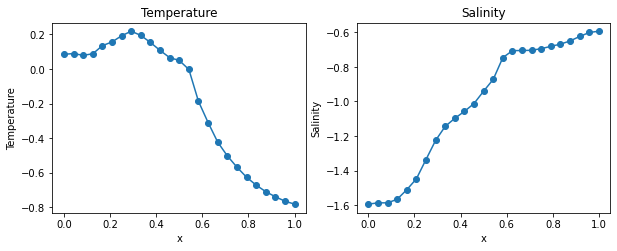

In [2]:
import pandas as pd
df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)

from utils.general import data_normalization
temperature = df[2].to_numpy()
salinity = df[3].to_numpy()
print('temperature mean: {}'.format(temperature.mean()))
print('salinity mean: {}'.format(salinity.mean()))


nx = len(temperature) - 1
x = np.linspace(0, 1, nx +1)
temperature = data_normalization(temperature, 31.0, df[2].to_numpy().ptp())
salinity = data_normalization(salinity, 33.5, df[3].to_numpy().ptp())

fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
ax[0]. plot(x,temperature,'o-')
ax[0].set_title('Temperature')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Temperature')

ax[1].plot(x,salinity,'o-')
ax[1].set_title('Salinity')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Salinity')

## Initialization

In [3]:
33.5 -0.6

32.9

In [4]:
nx = nx
a,b = 0,1
omega = 1.0
oce_val1 = 0.5
oce_val2 = -0.6
gamma1 = 1.0e-7 #1.048e-4
gamma2 = 1.0e-7 #1.6e-3
print(f'gamma1   = {gamma1}, gamma2 = {gamma2}')
run = dual_data_run(nx,a,b,gamma1, gamma2, omega,omega,oce_val1,oce_val2, normalized_mean1=0.0, normalized_mean2=0.0)

beta1 = 0.5
beta2 = 0.5
run.misfit_reg_setup(beta1, beta2)

a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx + self.g1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx + self.g2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str, a1_adj_str, L1_adj_str, a2_state_str, L2_state_str, a2_adj_str, L2_adj_str)

gamma1   = 1e-07, gamma2 = 1e-07


## Distribution Setup

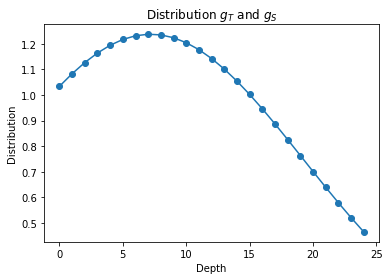

In [15]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/2
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.xlabel('Depth')
plt.ylabel('Distribution')
plt.title(r'Distribution $g_T$ and $g_S$')
# plt.savefig('./log/img/distribution.eps', bbox_inches='tight', dpi=300, format='eps')

## Boundary condition setup

In [6]:
from numpy import cos, pi, sin, exp
u1L_D = temperature[0]
u1R_D = temperature[-1]
u2L_N = 0.5
u2R_N = 0.0
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D},')
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.08460754332313947, Dirichlet_R: -0.781855249745158,
NBC_L: 0.5, NBC_R: 0.0


## Extra Forcing $g$

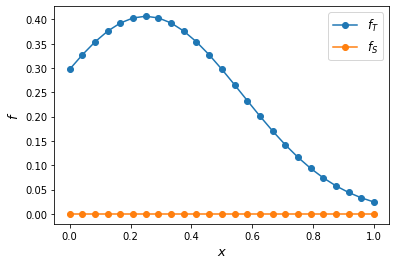

In [18]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.25
gauss_var = 1/5
g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g = normalize_function(g_str, run.Vm, ufl.dx)
g_array = g.compute_vertex_values()

coef = 0.25
g1 = dl.Function(run.Vu)
g1.vector().set_local(g_array[::-1]*coef)
coef = 0.0
g2 = dl.Function(run.Vu)
g2.vector().set_local(g_array[::-1]*coef)
run.extra_f_setup(g1 = g1, g2 = g2)

plt.plot(x,run.g1.compute_vertex_values(),'o-',label=r'$f_T$')
plt.plot(x,run.g2.compute_vertex_values(),'o-',label=r'$f_S$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$f$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt_forcing.eps', bbox_inches='tight',format='eps')
plt.show()

## Data Setup

-1.0139978331527624


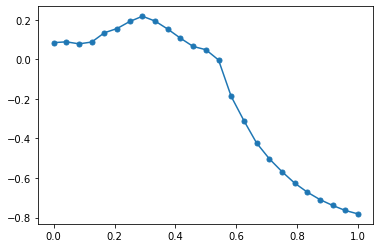

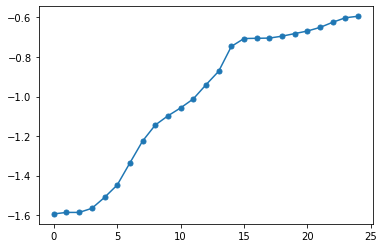

In [8]:
run.data_setup(temperature, salinity, normalize=False)

print(np.mean(run.ud2.compute_vertex_values()))
plt.plot(x,run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
# plt.plot(y2, '-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess 

Text(0, 0.5, '$u_2$')

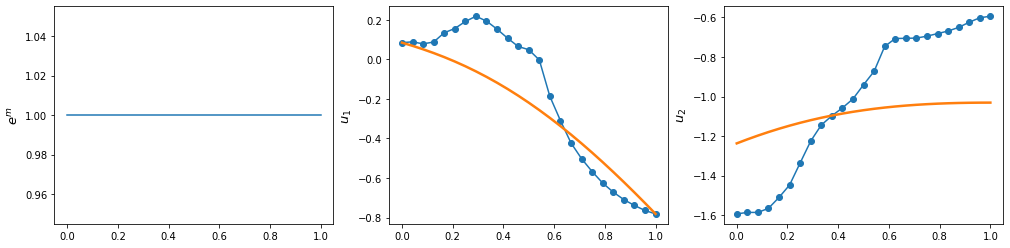

In [9]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(1)", degree=1),run.Vm)
# m.assign(m_true)
u1,u2,_,_,_,_ = run.fwd_solve(m)
# print(u1.compute_vertex_values()[0])
# print(u1.compute_vertex_values()[-1])
# print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
# print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
ax[0].plot(x, np.exp(m.compute_vertex_values()))
ax[0].set_ylabel('$e^m$', fontsize=13)

ax[1].plot(x, run.ud1.compute_vertex_values(), '-o')
ax[1].plot(x, u1.compute_vertex_values(), linewidth=2.5)
ax[1].set_ylabel('$u_1$', fontsize=13)

ax[2].plot(x, run.ud2.compute_vertex_values(), '-o')
ax[2].plot(x, u2.compute_vertex_values(),linewidth=2.5)
ax[2].set_ylabel('$u_2$', fontsize=13)

## Optimization Loop

In [10]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter, save_opt_log=False, plot_opt_step=False, plot_eigval=False)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     89   1.52980e-02   3.05960e-02   5.48381e-09   1.27789e-01   1.66816e-02   1.00000e+00   1.00e+00   5.000e-01
 2      2   6.70574e-03   1.34107e-02   7.74412e-07   1.38864e-01   2.64614e-02   1.58627e+00   1.00e+00   5.000e-01
 3      2   4.86955e-03   9.73849e-03   6.06532e-07   1.08812e-01   1.45874e-02   8.74459e-01   5.00e-01   5.000e-01
 4      1   4.53724e-03   9.07382e-03   6.56332e-07   3.56921e-02   1.23342e-02   7.39391e-01   1.00e+00   5.000e-01
 5      2   3.58118e-03   7.16025e-03   2.09967e-06   7.75359e-02   1.34223e-02   8.04616e-01   1.00e+00   5.000e-01
 6      2   2.41481e-03   4.82756e-03   2.05974e-06   6.97003e-02   9.62974e-03   5.77268e-01   1.00e+00   5.000e-01
 7      1   2.16849e-03   4.33489e-03   2.09487e-06   3.71939e-02   8.20173e-03   4.91664e-01   5.00e-01   4.917e-01
 8      2   1.74024e-03   3.47762e-03   2.86431e-06   5.50618e-02   6.67053e-03   3.

## Result Plotting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


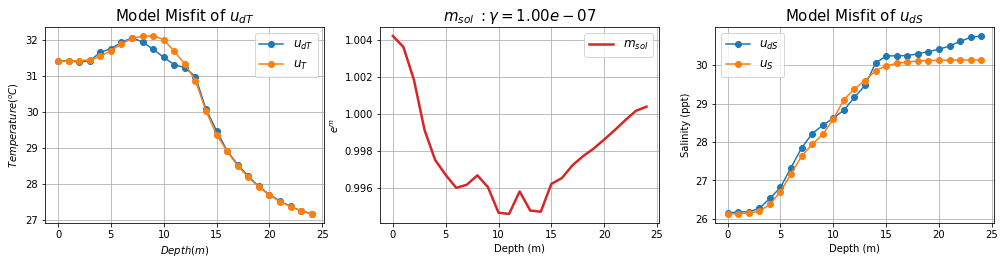

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 3.6)) 
std = df[2].to_numpy().ptp()
ax[0].plot(run.ud1.compute_vertex_values() * std + 31.0, 'o-', label=r'$u_{dT}$')
ax[0].plot(u1.compute_vertex_values() * std + 31.0, 'o-', label=r'$u_{T}$')
ax[0].set_xlabel(r'$Depth (m)$')
ax[0].set_ylabel(r'$Temperature (^oC)$')
ax[0].set_title(r'Model Misfit of $u_{dT}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

# mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
# ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(np.exp(m.compute_vertex_values() / (nx+1)**2), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'Depth (m)')
ax[1].set_ylabel(r'$e^m$')
ax[1].set_title(r'$m_{sol}$ '+f'$: \gamma = {run.gamma:1.2e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

std = df[3].to_numpy().ptp()
ax[2].plot(run.ud2.compute_vertex_values() * std + 33.5, 'o-', label=r'$u_{dS}$')
ax[2].plot(u2.compute_vertex_values() * std + 33.5, 'o-', label=r'$u_{S}$')
ax[2].set_xlabel(r'Depth (m)')
ax[2].set_ylabel(r'Salinity (ppt)')
ax[2].set_title(r'Model Misfit of $u_{dS}$', fontsize=15)
ax[2].grid()
ax[2].legend(fontsize=12)

plt.savefig('./log/img/double_data_real_result.eps', bbox_inches='tight',format='eps')

# print(np.linalg.norm(np.exp(m_true.compute_vertex_values()) - np.exp(m.compute_vertex_values())))